### Demonstration of the LsstCameraFootprint ###

The `LsstCameraFootprint` is a class that reads a pre-calculated footprint map for the LSST camera field of view (which includes chip gaps) and then when provided with a list of either pointings of interest, or one object pointing but several boresight pointings, returns the indexes of the points which landed on silicon. 

The footprint map is derived from the LSST DM camera model in `obs_lsst`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rubin_sim.data import get_data_dir
from rubin_sim.utils import LsstCameraFootprint

In [3]:
import numpy.lib.recfunctions as rfn

def makeDataValues(size=100, ramin=0, ramax=2*np.pi,
                   decmin=-np.pi, decmax=np.pi, random=1172):
    """Generate a simple array of numbers, evenly arranged between min/max,
    in 1 dimensions (optionally sorted), together with RA/Dec values
    for each data value."""
    rng = np.random.RandomState(random)
    randorder = rng.rand(size)
    randind = np.argsort(randorder)
    # Generate RA/Dec values equally spaces on sphere between ramin/max, decmin/max.
    ra = np.arange(0, size, dtype='float')
    ra *= (float(ramax) - float(ramin)) / (ra.max() - ra.min())
    randorder = rng.rand(size) 
    randind = np.argsort(randorder)
    ra = ra[randind] + ramin
    v = np.arange(0, size, dtype='float')
    v *= ((np.cos(decmax+np.pi) + 1.)/2.0 - (np.cos(decmin+np.pi)+1.)/2.0) / (v.max() - v.min())
    v += (np.cos(decmin+np.pi)+1.)/2.0
    dec = np.arccos(2*v-1) - np.pi
    randorder = rng.rand(size)
    randind = np.argsort(randorder)
    dec = dec[randind]
    # Add in rotation angle
    rot = rng.rand(len(dec))*2*np.pi
    return ra, dec, rot

In [4]:
camera = LsstCameraFootprint(units='radians', 
                             footprint_file=os.path.join(get_data_dir(), 'tests', 'fov_map.npz'))

In [5]:
pointing_ra = np.radians(15)
pointing_dec = np.radians(-20)
pointing_rot = np.radians(0)

In [6]:
# What happens if we pass one point, near the center of the fov?
eps = 0.00001
camera([pointing_ra+eps], [pointing_dec], pointing_ra, pointing_dec, 0)

array([0])

0.2251474735072685 0.2984513020910303
-0.3857177646907468 -0.312413936106985


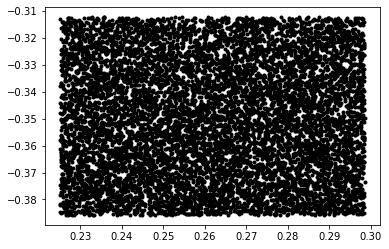

In [7]:
# Okay, let's set up a grid across and slightly beyond a whole FOV
rad = np.radians(2.1)
ramin = pointing_ra - rad
ramax = pointing_ra + rad
print(ramin, ramax)
decmin = pointing_dec - rad
decmax = pointing_dec + rad
print(decmin, decmax)
ra, dec, rot = makeDataValues(size=10000,
                    ramin=ramin, ramax=ramax,
                    decmin=decmin, decmax=decmax)
plt.plot(ra, dec, 'k.')

In [8]:
# Find which points fall onto the camera
idx = camera(ra, dec, pointing_ra, pointing_dec, pointing_rot)
idx

array([   0,    5,    6, ..., 9991, 9992, 9994])

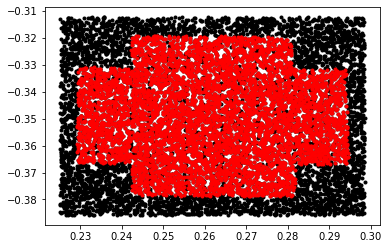

In [9]:
plt.plot(ra, dec, 'k.')
plt.plot(ra[idx], dec[idx], 'r.')

(-0.36, -0.35)

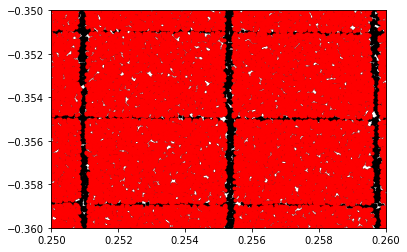

In [10]:
# zoom in

ra, dec, rot = makeDataValues(size=1000000,
                    ramin=ramin, ramax=ramax,
                    decmin=decmin, decmax=decmax)
idx = camera(ra, dec, pointing_ra, pointing_dec, pointing_rot)

plt.plot(ra, dec, 'k.')
plt.plot(ra[idx], dec[idx], 'r.')
plt.xlim(0.25, 0.26)
plt.ylim(-0.36, -0.35)

(-0.37, -0.36)

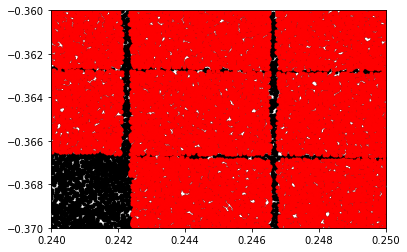

In [11]:
plt.plot(ra, dec, 'k.')
plt.plot(ra[idx], dec[idx], 'r.')
plt.xlim(0.24, 0.25)
plt.ylim(-0.37, -0.36)

In [12]:
# Or we could have a series of FOVs and one point of interest on the sky (wanting to find all intersection FOVs)
obj_ra=0.2945243112740431
obj_dec=0.0

pointing_ra, pointing_dec, pointing_rot = makeDataValues(size=1000, 
                                                         ramin=0, ramax=2*np.pi,
                                                         decmin=-np.pi, decmax=0,
                                                         random=55)

In [13]:
# So here we'll select a subset of points to send to the camera .. it's not entirely necessary, but
# a useful illustration of how the returned indexes should be combined with the first selection step
def calcDist_vincenty(RA1, Dec1, RA2, Dec2):
    """Calculates distance on a sphere using the Vincenty formula.
    Give this function RA/Dec values in radians. Returns angular distance(s), in radians.
    Note that since this is all numpy, you could input arrays of RA/Decs."""
    D1 = (np.cos(Dec2)*np.sin(RA2-RA1))**2 + \
        (np.cos(Dec1)*np.sin(Dec2) -
         np.sin(Dec1)*np.cos(Dec2)*np.cos(RA2-RA1))**2
    D1 = np.sqrt(D1)
    D2 = (np.sin(Dec1)*np.sin(Dec2) +
          np.cos(Dec1)*np.cos(Dec2)*np.cos(RA2-RA1))
    D = np.arctan2(D1, D2)
    return D

nearby_idx = np.where(calcDist_vincenty(obj_ra, obj_dec, pointing_ra, pointing_dec) < 0.5)
idx = camera(obj_ra, obj_dec, pointing_ra[nearby_idx], pointing_dec[nearby_idx], pointing_rot[nearby_idx])
print(nearby_idx[0], idx)
idx = nearby_idx[0][idx]

pointing_ra[idx], pointing_dec[idx]

[ 13  27  66 150 161 322 397 415 431 478 522 572 581 605 653 672 676 707
 821 848 899 905 977 989] [12]


(array([0.28931584]), array([0.]))

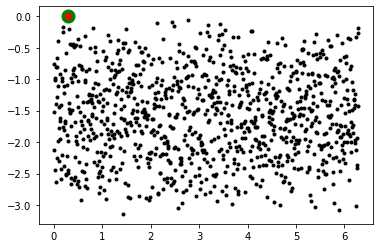

In [14]:
plt.plot(pointing_ra, pointing_dec, 'k.')
plt.plot(pointing_ra[idx], pointing_dec[idx], 'go', markersize=13)
plt.plot(obj_ra, obj_dec, 'ro')